# Data Organization for linArray_app

In [1]:
#load libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import math
import alignment_functions as af
import PyTrack.etDataReader as et

In [2]:
#dir( af )

In [3]:
from os import listdir
from os.path import isfile, join
mypath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print( onlyfiles )

['T35_083018_t1_spikingDAT.mat', 'T35_083018_t2_spikingDAT.mat', 'T35_083018_t2-01.plx', 'T35_083018_t2.plx', 'T35_083018_t3.plx', 'T35_083018_t1.plx', 'T35_083018_t3_spikingDAT.mat', 'T35_083018_t1-01.plx']


In [4]:
#load .mat into python environment @ new machine
chosen_data = onlyfiles[6]
linArrayPath = mypath + chosen_data
linArrayMat = loadmat( linArrayPath )
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals' )
multi_dSacctrials.shape

(70, 20)

In [5]:
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals', timeint = [0., 340.] )
addStrobes = multi_dSacctrials.copy()
addStrobes = af.addEventMarker( linArrayMat, addStrobes, [ 30, 40, 555, 666, 100 ], 'delayedSaccIntervals' )

In [6]:
# aligning neural data
stimOn = 555 #define the eventmarker for stimulus onset
multi_DSalign = af.addStimOnset( addStrobes, stimOn, 'SPK' )

In [7]:
stimOnCols = af.getDataTypeNames( multi_DSalign, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
time_axis_limits_ms = [ -50, 150 ]

In [8]:
#load behavioral .mat into python environment
path = "/home/bonzilla/Documents/ScienceLife/linArray/bhv_083018/"

bhv_file = "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(3).mat"
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat" #holds 22 trials, 14 correct trials Track2 RF mapping == T35_083018_t2_delayedSaccade.pkl
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(2).mat" #holds 52 trials, 41 correct trials Track2 RF+180
bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(3).mat" #holds 82 trials, 70 correct trials ???
#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1).mat" #holds 152 trials, 64 correct trials Track1?
bhvMat = loadmat( bhvPath )

In [9]:
BHV_df = af.bhvmat2pandasdf( bhvMat )
BHV_plusEV = af.addMultiEventVariables( BHV_df, [ 30, 40, 666, 100 ] )
print( BHV_plusEV.shape )
# select just the correct trials
BHV_correct = BHV_plusEV[
    BHV_plusEV['Trial_Error']==0].reset_index()
print( BHV_correct.shape )

(82, 10)
(70, 11)


In [10]:
#merging neural & behavioral data 
column_list = [ 'AnalogEyeData', 'bhv_code30', 'bhv_code40', 'bhv_code666' ]
mergedDS = af.mergeBehavioralColumn( 
    multi_DSalign, BHV_correct, column_list )
mergedDS = af.split_analog_eye( mergedDS, 'AnalogEyeData' )

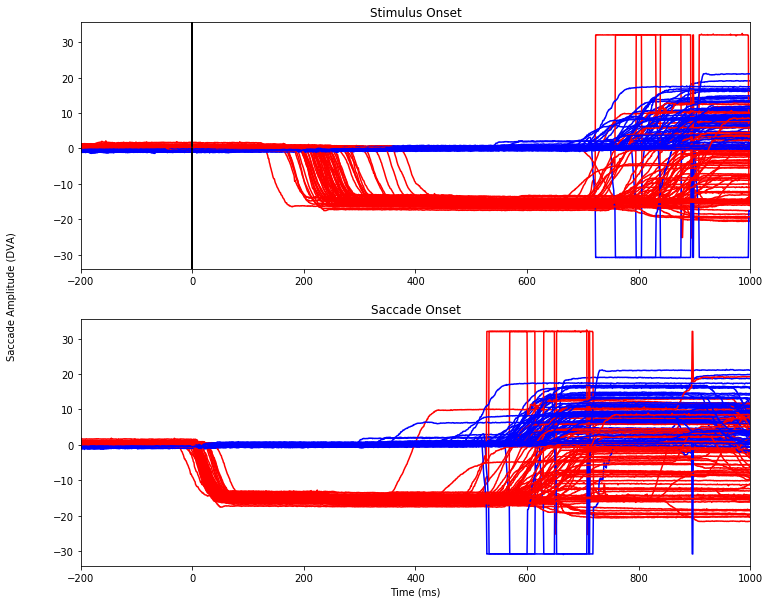

In [11]:
merged_bothAlign = af.add_saccade_onsets( mergedDS, 'bhv_code40', 'bhv_code666' )
stimOn_eyealign = af.alignments4trials( merged_bothAlign, 'bhv_code40', 'saccade_onset', 0 )
plt.show( stimOn_eyealign )

In [12]:
merged_bothAlign = af.adjustSpikes_SaccadeStart( merged_bothAlign, 'saccade_onset', 'SPK' )

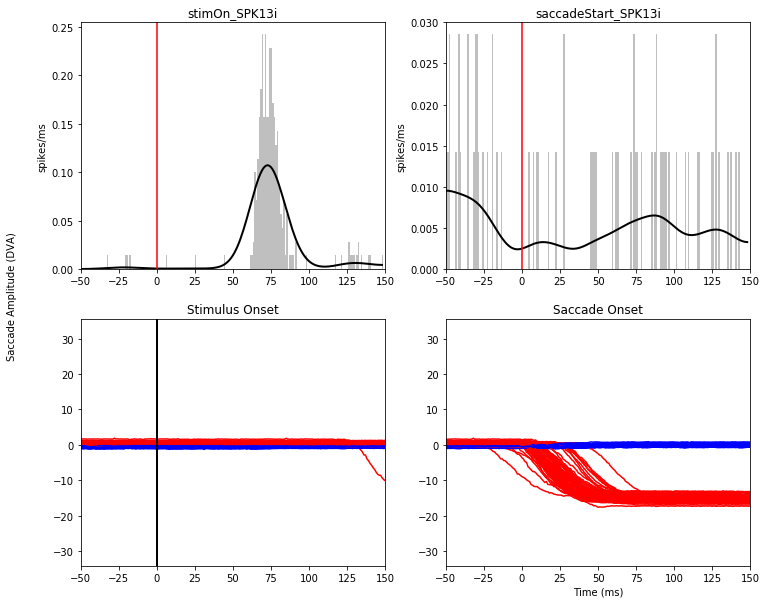

In [13]:
combinedalign = af.eyespike_dualAligned( merged_bothAlign, 'SPK13i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [14]:
merged_bothAlign = merged_bothAlign.assign( neuralDat = chosen_data, BHVdat = bhv_file )

In [ ]:
merged_bothAlign.to_pickle("T35_083018_t3_delayedSaccade.pkl")